# CmdStanPy and ArviZ integration
> "Embrace labeled multi-dimensional arrays for better exploratory analysis of your Bayesian models"

- toc: true 
- author: Oriol Abril
- badges: true
- categories: [python, arviz, stan, xarray, xarray-einstats]
- tags: [arviz converters, posterior predictive]
- image: images/nb/hmm_drive.png
- twitter_large_image: true

This blog post is an adaptation of the [Tagging Basketball Events with HMM in Stan](https://mc-stan.org/users/documentation/case-studies/bball-hmm.html) case study. It will not cover any new topics or analysis and assumes you have at least skimmed the original case study.

So what is this post about? I will use cmdstanpy+ArviZ integration to show the potential of using labeled arrays when doing exploratory analysis of Bayesian models. I will use [xarray](https://xarray.dev/)'s automatic broadcasting and alignment of arrays and the `stats` module of [xarray-einstats](https://einstats.python.arviz.org) for posterior predictive sampling.

Each section maps to an example on the original case study: simple HMM example, tagging drive events and defensive assignment. All sections follow the same structure. 

The beginning is as concise as possible to avoid duplication: the data needed for the model is read, the model is compiled and sampled. If you are interested you'll be able to read the stan code of the model clicking on the "Show Output" buttons. We then move to the target of this blog post: conversion of the cmdstanpy fit to ArviZ `InferenceData` and postprocessing with [xarray](https://xarray.dev/) and [xarray-einstats](https://einstats.python.arviz.org).

In [1]:
import cmdstanpy
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
#hide
# use text display to keep blog fast and responsive, 
# do not execute this cell when running the code
xr.set_options(display_style="text");

In [3]:
az.style.use("arviz-darkgrid")

## Simple HMM example
Link to [this same section](https://mc-stan.org/users/documentation/case-studies/bball-hmm.html#simple-hmm-example) in the original Stan case study.

In [32]:
hmm_data = pd.read_csv("data/hmm_example.csv")

Click the button below to see the Stan code:

In [5]:
#collapse-output
with open("stan_codes/hmm_example.stan", "r") as f:
    print(f.read())

// simple hmm example (1 output; 2 states)
data {
  int<lower=0> N;
  int<lower=0> K;
  real y[N];
}

parameters {
  simplex[K] theta[K];
  // real mu[K];
  positive_ordered[K] mu;
}

model {
  // priors
  target+= normal_lpdf(mu[1] | 3, 1);
  target+= normal_lpdf(mu[2] | 10, 1);
  // forward algorithm
  {
  real acc[K];
  real gamma[N, K];
  for (k in 1:K)
    gamma[1, k] = normal_lpdf(y[1] | mu[k], 1);
  for (t in 2:N) {
    for (k in 1:K) {
      for (j in 1:K)
        acc[j] = gamma[t-1, j] + log(theta[j, k]) + normal_lpdf(y[t] | mu[k], 1);
      gamma[t, k] = log_sum_exp(acc);
    }
  }
  target += log_sum_exp(gamma[N]);
  }
}

generated quantities {
  int<lower=1,upper=K> z_star[N];
  real log_p_z_star;
  {
    int back_ptr[N, K];
    real best_logp[N, K];
    for (k in 1:K)
      best_logp[1, k] = normal_lpdf(y[1] | mu[k], 1);
    for (t in 2:N) {
      for (k in 1:K) {
        best_logp[t, k] = negative_infinity();
        for (j in 1:K) {
          real logp;
          logp = 

In [6]:
model = cmdstanpy.CmdStanModel(stan_file="stan_codes/hmm_example.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [7]:
stan_data = dict(N = len(hmm_data), K = 2, y = hmm_data["y"])
hmm_fit = model.sample(data = stan_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


### Conversion to `InferenceData`
To convert a CmdStanPy fit to `InferenceData`, only the `CmdStanMCMC` object is needed. However, to make the most out of ArviZ and xarray features, the dimensions of each variable should also be provided.

Optionally, you can also give coordinate values to some of the dimensions. The dimensions without coordinate values provided are initialized with integers starting from 0 as their coordinate values.

Dimensions are provided as a dictionary whose keys are variable names and whose values are a list with the dimension names.

Coordinates are provided as a dictionary whose keys are now dimension names, and whose values are coordinate values.

In [36]:
states = [1, 2]
idata = az.from_cmdstanpy(
    hmm_fit,
    dims={"theta": ["origin_state", "end_state"], "mu": ["state"], "z_star": ["time"]},
    coords={"state": states, "origin_state": states, "end_state": states}
)
idata

Inference data with groups:
	> posterior
	> sample_stats

We have now created an `InferenceData` object with two groups, the `posterior` (shown below) contains all posterior samples, and the `sample_stats` one contains sampler information like the log probability, which samples are divergent or the treedepth.

Each group is an [xarray.Dataset](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset). As you can see, `Dataset`s have dimensions, coordinates, data variables and attributes. When printed (either as text or as html repr) each element has its own section with the relevant information.

The dimensions section lists all the dimensions and their lenghts. There we can quickly see that we have 2 states, and have sampled 1000 draws in 4 independent chains...

The coordinates section lists information in the following order: coordinate name, dimension name, type of coordinate values and coordinate values. Moreover, in the beginning there can be an `*` which indicates it is an indexing coordinate. With indexing coordinates, you can use `.sel` method on either `InferenceData` or `Dataset` to select a subset of the data using coordinate values.

The data variables lists: variables name, dimensions, type and values. Each variable, stored as a `DataArray` object, is independent of the others. They can have any of the dimensions of the `Dataset` and in any order.

The attributes section lists `Dataset` level attributes. By default, ArviZ adds some attributes to give an idea of how the data was generated.

In [35]:
idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, origin_state: 2, end_state: 2,
                   state: 2, time: 100)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * origin_state  (origin_state) int64 1 2
  * end_state     (end_state) int64 1 2
  * state         (state) int64 1 2
  * time          (time) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
Data variables:
    theta         (chain, draw, origin_state, end_state) float64 0.537 ... 0....
    mu            (chain, draw, state) float64 3.335 8.763 2.639 ... 3.078 8.938
    z_star        (chain, draw, time) float64 1.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    log_p_z_star  (chain, draw) float64 -166.1 -166.9 -166.3 ... -167.1 -166.0
Attributes:
    created_at:                 2022-04-24T22:54:42.066604
    arviz_version:              0.12.0
    inference_library:          cmdstanpy
    inference_library_version:  1.0.1

### Diagnostics
`arviz.summary` gives an overview of the fit with both summary statistics and diagnostics.

In [9]:
az.summary(idata, var_names=["theta", "mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"theta[1, 1]",0.668,0.100,0.479,0.846,0.002,0.001,3107.0,2035.0,1.0
"theta[1, 2]",0.332,0.100,0.154,0.521,0.002,0.001,3107.0,2035.0,1.0
"theta[2, 1]",0.073,0.029,0.024,0.126,0.001,0.000,2718.0,1969.0,1.0
"theta[2, 2]",0.927,0.029,0.874,0.976,0.001,0.000,2718.0,1969.0,1.0
mu[1],3.016,0.221,2.613,3.432,0.005,0.003,2012.0,2147.0,1.0
mu[2],8.828,0.111,8.611,9.032,0.002,0.001,4296.0,3005.0,1.0


We can customize the appearance of the summary with the `labeller` argument. The `arviz.labels` module includes some common labeller classes. The default is showing only variable name and coordinate values. We will now use the `DimCoordLabeller` to show also the dimension name:

In [10]:
az.summary(idata, var_names=["theta", "mu"], labeller=az.labels.DimCoordLabeller())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"theta[origin_state: 1, end_state: 1]",0.668,0.100,0.479,0.846,0.002,0.001,3107.0,2035.0,1.0
"theta[origin_state: 1, end_state: 2]",0.332,0.100,0.154,0.521,0.002,0.001,3107.0,2035.0,1.0
"theta[origin_state: 2, end_state: 1]",0.073,0.029,0.024,0.126,0.001,0.000,2718.0,1969.0,1.0
"theta[origin_state: 2, end_state: 2]",0.927,0.029,0.874,0.976,0.001,0.000,2718.0,1969.0,1.0
mu[state: 1],3.016,0.221,2.613,3.432,0.005,0.003,2012.0,2147.0,1.0
mu[state: 2],8.828,0.111,8.611,9.032,0.002,0.001,4296.0,3005.0,1.0


Further guidance on sorting and customizing ArviZ labels can be found in the [ArviZ label guide](https://python.arviz.org/en/latest/user_guide/label_guide.html)

### Posterior predictive sampling
Following the case study, we will perform posterior predictive sampling in Python instead of in the `generated_quantities` block of Stan. We will use [xarray-einstats](https://einstats.python.arviz.org/en/latest/) to generate the random samples from xarray objects.

In [37]:
from xarray_einstats.stats import XrContinuousRV
from scipy.stats import norm

post = idata.posterior

psi_seq = post["mu"].sel(state=post["z_star"])
# the conversion to dataset is for dislpay reasons only
psi_seq.to_dataset(name="psi_seq")

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, time: 100)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    state    (chain, draw, time) int64 1 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    psi_seq  (chain, draw, time) float64 3.335 8.763 8.763 ... 8.938 8.938 8.938

When we do `.sel(state=DataArray)` we are telling xarray to use the values in the provided `DataArray` as labels with which to index the `state` dimension. xarray takes care of aligning and broadcasting the dimensions for the indexing to work and generates the desired 3d array with chain, draw and time dimensions.

With the means that correspond to each posterior predictive sample, we need to generate random draws from a normal with mean `mu` and standard deviation `1`. 
xarray-einstats provides the [XrContinuousRV](https://einstats.python.arviz.org/en/latest/tutorials/stats_tutorial.html#probability-distributions) class to wrap SciPy distributions and have them take `DataArray`s as inputs. 

We can then generate the distribution and generate the random samples with the `rvs` method like we would do with SciPy. The `to_dataset` method is called so we can then add the data as a new group to our `InferenceData`.

In [38]:
idata.add_groups(posterior_predictive=XrContinuousRV(norm, psi_seq, 1).rvs().to_dataset(name="y"))
print(idata)
idata.posterior_predictive

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats


<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, time: 100)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    state    (chain, draw, time) int64 1 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    y        (chain, draw, time) float64 3.875 9.168 8.93 ... 8.58 7.509 8.855

Before plotting we will use the [extract_dataset](https://python.arviz.org/en/latest/api/generated/arviz.extract_dataset.html) function to get a random subset of 100 samples. Plotting the 4000 samples we have available would be excessive and not add any information to the plot.

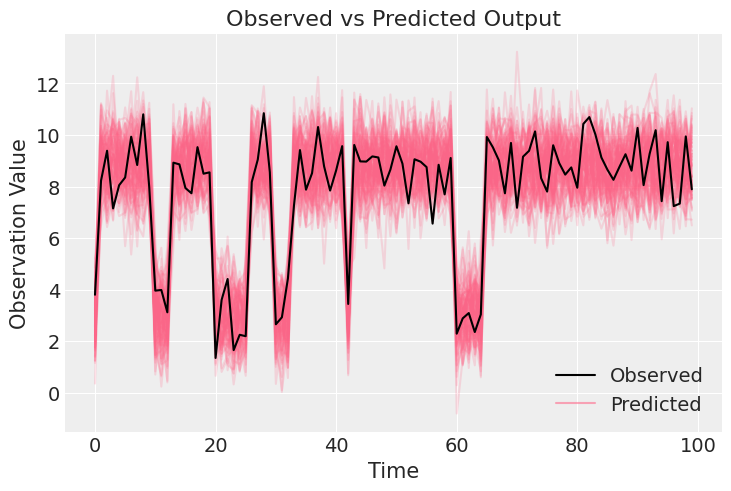

In [40]:
pp_subset = az.extract_dataset(idata, group="posterior_predictive", num_samples=100)

_, ax = plt.subplots()
ax.plot(hmm_data["y"], "k-", zorder=3, label="Observed")
ax.set_title("Observed vs Predicted Output")
ax.set_ylabel("Observation Value")
ax.set_xlabel("Time")

ax.plot(pp_subset["y"], color="#ff668890", alpha=.2)
ax.plot([], [], color="#ff668890", label="Predicted")
ax.legend();

## Tagging Drive Events
Link to [this same section](https://mc-stan.org/users/documentation/case-studies/bball-hmm.html#tagging-drive-events) in the original Stan case study.

In [13]:
df = pd.read_csv("data/evt140_0021500411.csv")

In [14]:
stan_data = dict(
    N = len(df),
    K = 2,
    u = np.log(1/df["lavine_speed_smooth"].values),
    v = np.log(df["lavine_dist"].values),
    alpha = np.array([[4,2],[2,4]]),
    tau = 0.1,
    rho = 0.1
)

In [15]:
#collapse-output
with open("stan_codes/drive_1.stan", "r") as f:
    print(f.read())

// drive model (normal dist)
data {
  int<lower=1> K;               // number of states (1 = none, 2 = drive)
  int<lower=1> N;               // length of process
  real u[N];                    // 1/speed
  real v[N];                    // hoop distance
  matrix<lower=0>[K,K] alpha;   // transit prior
  real<lower=0> tau;            // sd u
  real<lower=0> rho;            // sd v
}
parameters {
  simplex[K] theta[K];          // transit probs
  // enforce an ordering: phi[1] <= phi[2] 
  ordered[K] phi;      // emission parameter for 1/speed
  ordered[K] lambda;   // emission parameter for hoop dist
}
model {
  // priors
  for (k in 1:K)
    target += dirichlet_lpdf(theta[k] | alpha[k,]');
  target+= normal_lpdf(phi[1] | 0, 1);
  target+= normal_lpdf(phi[2] | 3, 1);
  target+= normal_lpdf(lambda[1] | 0, 1);
  target+= normal_lpdf(lambda[2] | 3, 1);
  // forward algorithm
  {
    real acc[K];
    real gamma[N,K];
    for (k in 1:K)
      gamma[1,k] = normal_lpdf(u[1] | phi[k], tau) + n

In [16]:
model = cmdstanpy.CmdStanModel(stan_file="stan_codes/drive_1.stan")

INFO:cmdstanpy:found newer exe file, not recompiling


In [17]:
drive_fit = model.sample(data = stan_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


### Conversion to `InferenceData`
In this example we also use the `observed_data` argument to add some data to the `observed_data` group. This can be useful to have the observations also as xarray objects and ease postprocessing operations, or to share the model and InferenceData file for collaborators to reproduce the fit or work with the results directly.

In [42]:
states = [1, 2]
drive_idata = az.from_cmdstanpy(
    drive_fit,
    dims={
        "theta": ["origin_state", "end_state"], 
        "alpha": ["origin_state", "end_state"], 
        "phi": ["state"], 
        "lambda": ["state"], 
        "z_star": ["time"],
        "v": ["time"],
        "u": ["time"],
    },
    observed_data={k: v for k, v in stan_data.items() if k in {"u", "v", "alpha"}},
    coords={"state": states, "origin_state": states, "end_state": states}
)
drive_idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, origin_state: 2, end_state: 2,
                   state: 2, time: 416)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * origin_state  (origin_state) int64 1 2
  * end_state     (end_state) int64 1 2
  * state         (state) int64 1 2
  * time          (time) int64 0 1 2 3 4 5 6 7 ... 409 410 411 412 413 414 415
Data variables:
    theta         (chain, draw, origin_state, end_state) float64 0.9664 ... 0...
    phi           (chain, draw, state) float64 -2.379 -0.7464 ... -2.332 -0.7441
    lambda        (chain, draw, state) float64 2.421 3.542 2.425 ... 2.423 3.534
    z_star        (chain, draw, time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0
    log_p_z_star  (chain, draw) float64 -6.908e+03 -6.904e+03 ... -6.905e+03
Attributes:
    created_at:                 2022-04-24T23:29:53.782668
    arviz_version:              0.12.0
    inference_library:          cmdstanpy
    inference_library_version:  1.0.1

### Posterior predictive sampling
We use again the same functions as before, with only a small difference, we now use `.sel` on a `Dataset` with the two variables of interest instead of a `DataArray`. As you can see, everything works the same.

In [19]:
post = drive_idata.posterior

ds_seq = post[["phi", "lambda"]].sel(state=post["z_star"])
phi_hat = XrContinuousRV(norm, ds_seq["phi"], .1).rvs()
lambda_hat = XrContinuousRV(norm, ds_seq["lambda"], .1).rvs()

drive_idata.add_groups(
    posterior_predictive=xr.Dataset({"phi": phi_hat, "lambda": lambda_hat})
)
drive_idata.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, time: 416)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    state    (chain, draw, time) int64 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 408 409 410 411 412 413 414 415
Data variables:
    phi      (chain, draw, time) float64 -0.7508 -0.904 ... -0.6576 -0.8262
    lambda   (chain, draw, time) float64 3.422 3.491 3.549 ... 3.443 3.603 3.345

We end reproducing the plot in the original case study to show that the posterior predictive samples do indeed look the same.

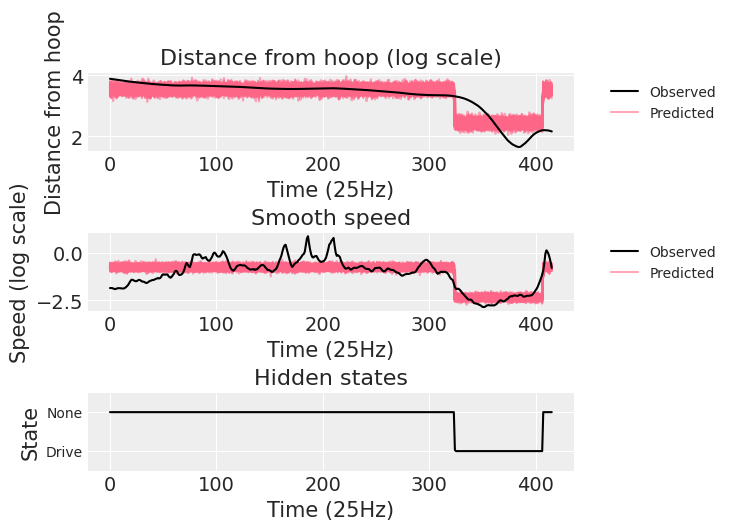

In [20]:
pp_subset = az.extract_dataset(drive_idata, group="posterior_predictive", num_samples=100)
obs_data = drive_idata.observed_data

_, axes = plt.subplots(3, 1)
ax = axes[0]
ax.plot(obs_data["v"], "k-", zorder=3, label="Observed")
ax.set_title("Distance from hoop (log scale)")
ax.set_ylabel("Distance from hoop")
ax.set_xlabel("Time (25Hz)")

ax.plot(pp_subset["lambda"], color="#ff668890")
ax.plot([], [], color="#ff668890", label="Predicted")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="medium");

ax = axes[1]
ax.plot(obs_data["u"], "k-", zorder=3, label="Observed")
ax.set_title("Smooth speed")
ax.set_ylabel("Speed (log scale)")
ax.set_xlabel("Time (25Hz)")

ax.plot(pp_subset["phi"], color="#ff668890")
ax.plot([], [], color="#ff668890", label="Predicted")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="medium");

ax = axes[2]
ax.plot(post["z_star"].mean(("chain", "draw")), "k-")
ax.set_title("Hidden states")
ax.set_ylabel("State")
ax.set_xlabel("Time (25Hz)")
ax.set_ylim((.5, 2.5))
ax.set_yticks([1, 2], labels=["Drive", "None"], size="medium");

## Defensive assignment
Link to [this same section](https://mc-stan.org/users/documentation/case-studies/bball-hmm.html#defensive-assignment) in the original Stan case study.

In [21]:
ds = xr.open_dataset("data/defense_example.nc")
print(ds)

<xarray.Dataset>
Dimensions:  (coord: 2, time: 20, player: 5)
Coordinates:
  * coord    (coord) object 'x' 'y'
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * player   (player) int64 0 1 2 3 4
Data variables:
    N        int64 ...
    K        int64 ...
    tau      float64 ...
    h        (coord) float64 ...
    b        (time, coord) float64 ...
    o        (player, time, coord) float64 ...
    d        (time, coord) float64 ...


In [22]:
stan_data = {k: v.item() if v.size == 1 else v.values for k, v in ds.items()}

In [23]:
#collapse-output
with open("stan_codes/defense_0a.stan", "r") as f:
    print(f.read())

// defensive model 0.a (lambda fixed)
data {
  int<lower=0> N;
  int<lower=0> K;
  real<lower=0> tau;
  real lambda[3];
  vector[2] h;
  vector[2] b[N];  // array of size N containing vectors of size 2
  vector[2] d[N];
  vector[2] o[K,N];   // array of size K,N containing vectors of size 2
}

parameters {
  simplex[K] theta[K];
}

model {
  // forward algorithm
  {
  real acc[K];
  real gamma[N, K];
  for (k in 1:K)
    gamma[1, k] = normal_lpdf(d[1] |  o[k,1]*lambda[1] + h*lambda[2] + b[1]*lambda[3], tau);
  for (t in 2:N) {
    for (k in 1:K) {
      for (j in 1:K)
        acc[j] = gamma[t-1, j] + log(theta[j, k])
          + normal_lpdf(d[t] |  o[k,t]*lambda[1] + h*lambda[2] + b[t]*lambda[3], tau);
      gamma[t, k] = log_sum_exp(acc);
    }
  }
  target += log_sum_exp(gamma[N]);
  }
}

generated quantities {
  int<lower=1,upper=K> z_star[N];
  real log_p_z_star;
  {
    int back_ptr[N, K];
    real best_logp[N, K];
    for (k in 1:K)
      best_logp[1, k] = normal_lpdf(d[1] |  o[k

In [24]:
model = cmdstanpy.CmdStanModel(stan_file="stan_codes/defense_0a.stan")
defense0a_fit = model.sample(data = {**stan_data, "lambda": [1/3, 1/3, 1/3]})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In this example we already have the data as an xarray object, so we won't use the `observed_data` group. If you still wanted to include it, it might be easier to use `.add_groups` with the already existing `Dataset` like we did with the posterior predictive samples.

In [25]:
states = [1, 2, 3, 4, 5]
defense0a_idata = az.from_cmdstanpy(
    defense0a_fit,
    dims={
        "theta": ["origin_state", "end_state"], 
        "z_star": ["time"],
    },
    coords={"state": states, "origin_state": states, "end_state": states}
)
defense0a_idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, origin_state: 5, end_state: 5, time: 20)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * origin_state  (origin_state) int64 1 2 3 4 5
  * end_state     (end_state) int64 1 2 3 4 5
  * time          (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    theta         (chain, draw, origin_state, end_state) float64 0.5028 ... 0...
    z_star        (chain, draw, time) float64 5.0 5.0 5.0 5.0 ... 2.0 2.0 2.0
    log_p_z_star  (chain, draw) float64 -3.639e+04 -3.64e+04 ... -3.64e+04
Attributes:
    created_at:                 2022-04-24T22:36:39.407969
    arviz_version:              0.12.0
    inference_library:          cmdstanpy
    inference_library_version:  1.0.1

In [26]:
#collapse-output
with open("stan_codes/defense_0b.stan", "r") as f:
    print(f.read())

// defensive model 0.b (lambda as parameter)
data {
  int<lower=0> N;
  int<lower=0> K;
  real<lower=0> tau;
  vector[3] alpha;
  vector[2] h;
  vector[2] b[N];  // array of size N containing vectors of size 2
  vector[2] d[N];
  vector[2] o[K,N];   // array of size K,N containing vectors of size 2
}

parameters {
  simplex[K] theta[K];
  simplex[3] lambda;
}

model {
  // priors
  target+= dirichlet_lpdf(lambda | alpha);
  // forward algorithm
  {
  real acc[K];
  real gamma[N, K];
  for (k in 1:K)
    gamma[1, k] = normal_lpdf(d[1] |  o[k,1]*lambda[1] + h*lambda[2] + b[1]*lambda[3], tau);
  for (t in 2:N) {
    for (k in 1:K) {
      for (j in 1:K)
        acc[j] = gamma[t-1, j] + log(theta[j, k])
          + normal_lpdf(d[t] |  o[k,t]*lambda[1] + h*lambda[2] + b[t]*lambda[3], tau);
      gamma[t, k] = log_sum_exp(acc);
    }
  }
  target += log_sum_exp(gamma[N]);
  }
}

generated quantities {
  int<lower=1,upper=K> z_star[N];
  real log_p_z_star;
  {
    int back_ptr[N, K];
    real

In [27]:
model = cmdstanpy.CmdStanModel(stan_file="stan_codes/defense_0b.stan")
defense0b_fit = model.sample(data = {**stan_data, "alpha": [3., 3., 3.]})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Here I have chosen `param` as dimension name for `lambda` because each component multiplies a different provided variable, and used `o, h, b` as coordinate names to match the variable names in the data block, but they could be `offensive player, hoop, ball` as well, there is no need to restrict oneself to one character coordinate values.

In [28]:
states = [1, 2, 3, 4, 5]
defense0b_idata = az.from_cmdstanpy(
    defense0b_fit,
    dims={
        "theta": ["origin_state", "end_state"],
        "lambda": ["param"],
        "z_star": ["time"],
    },
    coords={"state": states, "origin_state": states, "end_state": states, "param": ["o", "h", "b"]}
)
defense0b_idata.posterior

<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, origin_state: 5, end_state: 5,
                   param: 3, time: 20)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * origin_state  (origin_state) int64 1 2 3 4 5
  * end_state     (end_state) int64 1 2 3 4 5
  * param         (param) <U1 'o' 'h' 'b'
  * time          (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    theta         (chain, draw, origin_state, end_state) float64 0.5198 ... 0...
    lambda        (chain, draw, param) float64 0.5897 0.4103 ... 0.0001586
    z_star        (chain, draw, time) float64 5.0 1.0 1.0 1.0 ... 2.0 2.0 2.0
    log_p_z_star  (chain, draw) float64 -1.251e+04 -1.251e+04 ... -1.251e+04
Attributes:
    created_at:                 2022-04-24T22:37:09.720963
    arviz_version:              0.12.0
    inference_library:          cmdstanpy
    inference_library_version:  1.0.1

In [29]:
lambda0b = defense0b_idata.posterior["lambda"]

mu0a = ds["o"] / 3 + ds["h"] / 3 + ds["b"] / 3
mu0b = (
    ds["o"] * lambda0b.sel(param="o") 
    + ds["h"] * lambda0b.sel(param="h") 
    + ds["b"] * lambda0b.sel(param="b")
)

Note that `mu0b` is now a 5d array. Thanks to xarray automatic alignment and broadcasting capabilities we have calculated its values for all players, all time steps and all samples at once:

In [30]:
# conversion to dataset is only for display reasons
mu0b.to_dataset(name="mu0b")

<xarray.Dataset>
Dimensions:  (coord: 2, time: 20, player: 5, chain: 4, draw: 1000)
Coordinates:
  * coord    (coord) object 'x' 'y'
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * player   (player) int64 0 1 2 3 4
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    param    <U1 'b'
Data variables:
    mu0b     (player, time, coord, chain, draw) float64 -0.5923 ... -0.8203

This doesn't make any difference in this case, because we are multiplying the components of `lambda` by quantities that are not random variables, so we will get the same result averaging on `lambda` before operating or averaging on `mu` after operating. 

However, in many cases we need to operate with all the draws of each random variable. xarray makes it straightforward to work with all the samples and average only once we have the quantity of interest.

## Further reading
* [Working with InferenceData](https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html) page in the ArviZ docs

Package versions used to generate this post:

In [31]:
#hide_input
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray_einstats

Last updated: Mon Apr 25 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

xarray_einstats: 0.3.0.dev0

xarray    : 2022.3.0
matplotlib: 3.5.1
arviz     : 0.12.0
pandas    : 1.4.2
cmdstanpy : 1.0.1
numpy     : 1.21.5

Watermark: 2.3.0



---
Comments are not enabled for this post, to inquiry further about the contents of the post, ask on [Stan Discourse](https://discourse.mc-stan.org/). Feel free to tag me at [@OriolAbril](https://discourse.mc-stan.org/u/oriolabril/summary)